# XGBoost Extended Model all features general prediction and Framewise prediction
> Created Feb. 2025 <br>
> Nikhil Bisht<br>

In [12]:
# standard system modules
import os, sys
os.environ["PATH"] += os.pathsep + "/home/nbisht/myapps/bin/"
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
import xgboost as xgb

import sklearn.metrics as skm

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.json'
MCDSO_CORE = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_XGBoost_MCDS0_core.csv'
MCDSO_NONCORE = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_XGBoost_MCDS0_noncore.csv'

IMAGESIZE = 128

#In percentage
NTRAIN_percentage =  0.80
NVALID_percentage =  0.05
NTEST_percentage  =  0.20

ALL_COLUMNS = ['Particle_id', 'Initial_Frame', 'X_i', 'Y_i', 'Z_i', 'Vx_i', 'Vy_i', 'Vz_i', 'Density_i', 'X_f', 'Y_f', 'Z_f']#, 'Vx_f', 'Vy_f', 'Vz_f', 'Density_f']
FEATURES = ALL_COLUMNS[1:9]
TARGET = ALL_COLUMNS[9:]

FRAMES = np.arange(20,90, 1)
FRAME_DIFF = 30

NUM_X_TRAIN = 13

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

do_core = 1
if do_core == 1:
    df_timeseries = pd.read_csv(MCDSO_CORE)
    model_prefix = 'Core'
elif do_core == 0:
    df_timeseries = pd.read_csv(MCDSO_NONCORE)
    model_prefix = 'NonCore'
else:
    df_timeseries_core = pd.read_csv(MCDSO_CORE)
    df_timeseries_noncore = pd.read_csv(MCDSO_CORE)
    df_timeseries = pd.concat([df_timeseries_core, df_timeseries_noncore], axis=0)
    model_prefix = 'Combined'
df_timeseries

Available device: cpu 


,Particle_id,Initial_Frame,X_i,Y_i,Z_i,Vx_i,Vy_i,Vz_i,Density_i,X_f,Y_f,Z_f
0,1405,20,0.527180,0.158741,0.971439,6.421220,-1.876194,-5.372949,0.277539,0.574790,0.162447,0.928789
1,1488,20,0.100503,0.200606,0.966166,-4.441785,2.345180,-4.707516,0.974011,0.046665,0.217869,0.931834
2,1489,20,0.109401,0.206609,0.968732,-4.272087,3.115164,-4.167612,0.850971,0.060391,0.236572,0.929803
3,1490,20,0.118114,0.207084,0.971037,-4.146288,3.527104,-3.902281,0.941309,0.066567,0.240239,0.936063
4,1531,20,0.506000,0.168704,0.994022,6.933440,-1.068680,-1.719031,0.239841,0.579576,0.164281,0.945365
...,...,...,...,...,...,...,...,...,...,...,...,...
8215475,2095843,89,0.835269,0.284902,0.339996,3.356818,4.506277,-1.690823,12.974862,0.867902,0.336165,0.311914
8215476,2095871,89,0.107716,0.508404,0.352204,4.872550,3.780446,-8.586980,1.512863,0.139102,0.541064,0.257406
8215477,2095906,89,0.828956,0.303926,0.344030,3.392380,4.518692,-1.866807,6.594403,0.865761,0.353138,0.315775
8215478,2096034,89,0.838114,0.293587,0.338315,3.059779,4.365908,-1.606220,14.772669,0.870565,0.343483,0.311484


### Functions

In [14]:
def plot_prediction(y_true,y_pred, append=''):
    fig = plt.figure(figsize=(12, 4))
    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        ax.scatter(y_true[:,i], y_pred[:,i], c='crimson', s=1e-2)
        p1 = max(max(y_pred[:,i]), max(y_true[:,i]))
        p2 = min(min(y_pred[:,i]), min(y_true[:,i]))
        ax.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        ax.set_ylabel(TARGET[i])
        ax.set_xlim([-0.1,1.1])
        ax.set_ylim([-0.1,1.1])
    fig.tight_layout()
    plt.savefig('Particles_All_Frames_Frame'+str(FRAMES[0])+'_to_Frame'+str(FRAMES[-1])+'_Prediction'+append+'.png')
    plt.show()

def df_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['del_X'] = df['X_f'] - df['X_i']
    df['del_Y'] = df['Y_f'] - df['Y_i']
    df['del_Z'] = df['Z_f'] - df['Z_i']
    df['X_op'] = np.where(np.abs(df['X_i'])<distance_condition, -1, +1)
    df['Y_op'] = np.where(np.abs(df['Y_i'])<distance_condition, -1, +1)
    df['Z_op'] = np.where(np.abs(df['Z_i'])<distance_condition, -1, +1)
    df['X_f'] = np.where(np.abs(df['del_X'])<distance_condition, df['X_f'], df['X_f']+df['X_op'])
    df['Y_f'] = np.where(np.abs(df['del_Y'])<distance_condition, df['Y_f'], df['Y_f']+df['Y_op'])
    df['Z_f'] = np.where(np.abs(df['del_Z'])<distance_condition, df['Z_f'], df['Z_f']+df['Z_op'])
    return df

def df_inverse_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['X_f'] = np.where(np.abs(df['X_f'])>=1, df['X_f']-1, df['X_f'])
    df['X_f'] = np.where(np.abs(df['X_f'])<0, df['X_f']+1, df['X_f'])
    df['Y_f'] = np.where(np.abs(df['Y_f'])>=1, df['Y_f']-1, df['Y_f'])
    df['Y_f'] = np.where(np.abs(df['Y_f'])<0, df['Y_f']+1, df['Y_f'])
    df['Z_f'] = np.where(np.abs(df['Z_f'])>=1, df['Z_f']-1, df['Z_f'])
    df['Z_f'] = np.where(np.abs(df['Z_f'])<0, df['Z_f']+1, df['Z_f'])
    return df


def model_test(model, test_df, distance_condition = 0.5):
    y_pred = model.predict(test_df[FEATURES])
    y_pred_df = pd.DataFrame({'X_f': y_pred[:, 0], 'Y_f': y_pred[:, 1], 'Z_f': y_pred[:, 2]})
    y_pred_df =  df_inverse_transform(y_pred_df, distance_condition = distance_condition)
    
    return y_pred_df

## Split data

In [15]:
df_timeseries['Density_i'] = np.log10(df_timeseries['Density_i'])
df_timeseries_transformed = df_transform(df_timeseries)
X, y = df_timeseries_transformed[FEATURES], df_timeseries_transformed[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = NTEST_percentage,  random_state=seed)

y_test = df_inverse_transform(y_test)

## Train model
https://xgboost.readthedocs.io/en/stable/parameter.html

In [16]:
n_estimators    = [500, 800, 1500]  
max_depth       = [8 ,8, 8]
eta             = [0.1, 0.1, 0.01]
subsample       = [1, 1, 1]   
gamma           = [0.5, 0.5, 0.5]

best_models = [0 ,0 ,0]
for i in range(3):
    best_models[i] = xgb.XGBRegressor(n_estimators=n_estimators[i], max_depth=max_depth[i], eta=eta[i], subsample=subsample[i], gamma = gamma[i], device = 'cpu')
    best_models[i].fit(X_train, y_train)
    best_models[i].save_model(model_prefix+"_Extended_All_Frames_BestModel"+str(i)+"_"+MODELFILE)

print(len(X_train))

6572384


## Load Model

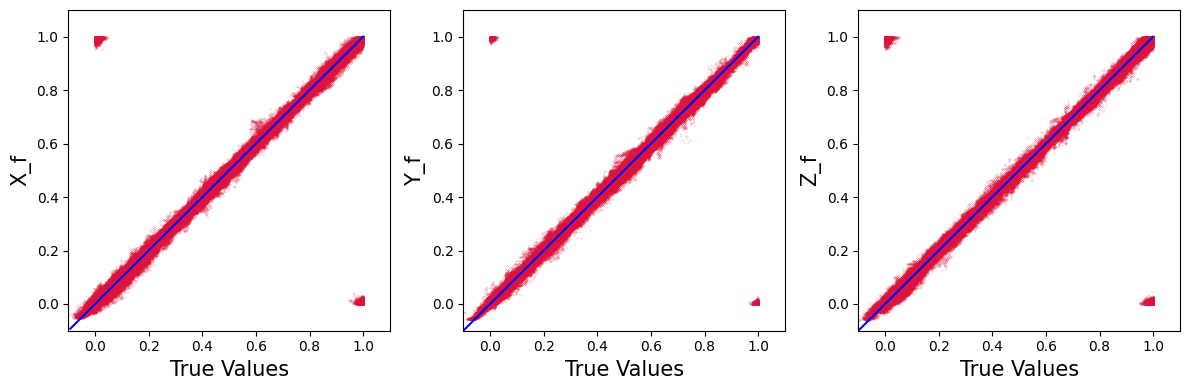

MSE: 0.008995
R2: 0.918


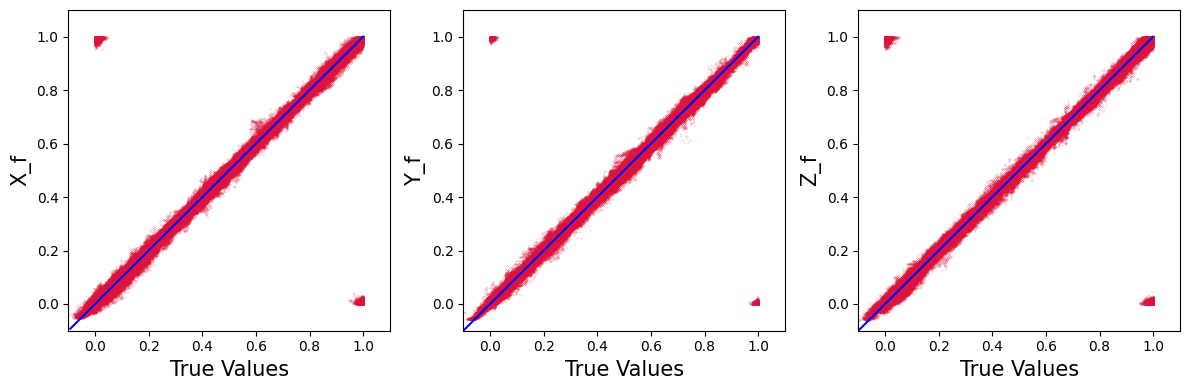

MSE: 0.008995
R2: 0.918


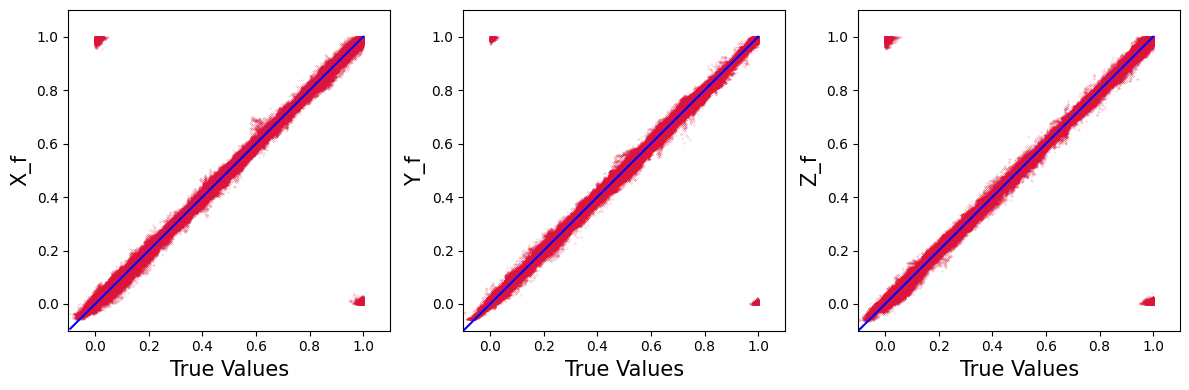

MSE: 0.008893
R2: 0.919


In [17]:
loaded_model = [0,0,0]
for i in range(3):
    loaded_model[i] = xgb.XGBRegressor()
    loaded_model[i].load_model(model_prefix+"_Extended_All_Frames_BestModel"+str(i)+"_"+MODELFILE)
    ypred, ytrue = model_test(loaded_model[i], X_test), y_test
    plot_prediction(ytrue.to_numpy(),ypred.to_numpy(), append = "_"+model_prefix+"_Extended_All_Frames_BestModel"+str(i))
    mse = skm.mean_squared_error(ytrue.to_numpy(), ypred.to_numpy())
    r2 = skm.r2_score(ytrue.to_numpy(),ypred.to_numpy())
    print('MSE: %.6f' % mse)
    print('R2: %.3f' % r2)



In [18]:
def mse_modded(y_true, y_pred):
    sqr_diff = np.abs(y_true - y_pred)
    sqr_diff = sqr_diff.flatten()
    sqr_add = 1-np.abs(y_true - y_pred)
    sqr_add = sqr_add.flatten()
    mse = 0
    for i in range(len(sqr_diff)):
        mse += min(sqr_diff[i], sqr_add[i])**2
    return mse/len(sqr_diff)

In [19]:
mse_m = mse_modded(ytrue.to_numpy(), ypred.to_numpy())
print('MSE modded: %.6f' % mse_m)


MSE modded: 0.000084


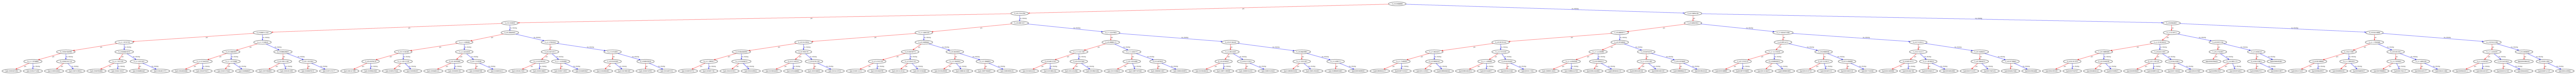

In [33]:
from io import BytesIO
import PIL
fig= plt.subplots(figsize=(210, 90))
g = xgb.to_graphviz(model, num_trees=0)
s = BytesIO()
s.write(g.pipe(format="eps"))
s.seek(0)
img = np.array(PIL.Image.open(s))
plt.imshow(img)
plt.axis("off")
plt.savefig("Extended_V0_more_features_model.png", dpi = 100)
plt.show()

## Stats
| Model 	| Loss 	        | n_estimators 	| max_depth 	| eta 	| subsample 	| lambda 	| alpha 	| Mean MAE 	| mse 	| r2 	| remarks 	                                     |
|-------	|-------        |--------------	|-----------	|-----	|-----------	|--------	|-------	|----------	|------	|----	|---------	                                    |
|Simple V0	|squarederror   |1000           |  7         	|1e-2 	|1/30        	|   1    	|    1  	| 0.023  	|0.005   |0.951	|Fails at periodic wrap                          |
|Simple V1	|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.019 	|0.004  	|0.964	|Suprisingly better than V0                     |
|Simple V2	|squarederror   |1000          	|  7        	|1e-2   | 3/4        	|   1    	|    1  	| 0.019 	|0.004  	|0.963	|Same as V1                                       |
|Periodic V0|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.004 	|0.04  	|-0.882	|Worse than linear fit lol (wrap from 3. to .7)              |
|Periodic V1|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.007 	|0.09  	|-21 lol	|Octant breakdown  doesn't work, individual models are worse off               |
|Extended_V0|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.003     |0.00364|0.968| yay works better for both core and noncore, maybe avg of 2 models shifted?|
|Extended_V0 (more features)|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.003     |0.00364|0.973| More features makes it better!|